# THIRD EXERCISE

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import sklearn
from sklearn.metrics.pairwise import euclidean_distances 
from matplotlib.ticker import MaxNLocator

# 1) k-means
## 1.a) standard k-means with random initialization
Iterate the following steps until convergence of the centroids:
- Randomly initialize $k$ centroids $c_l$ ($l=1,...,k$)
- Assign element $i$ to the a cluster $z_i$ ($z_i = 1,...,k$) according to the closest centroid:
\begin{equation}
    z_i = \underset{l}{\text{argmin}} \| X_i - c_l\|
\end{equation}
- Update the cluster centroids:
\begin{equation}
    c_l = \frac{\sum_{i=1}^N \delta_{iz_i}\,X_i}{\sum_{i=1}^N \delta_{iz_i}}
\end{equation}

The algorithms brings to the local minimization of the objective function
\begin{equation}
    O(z) = \sum_{i=1}^N \sum_{l=1}^k \delta_{iz_i} \| X_i - c_l\|^2
\end{equation}

In [37]:
def k_means(data, k=15, case='standard'):
    N = data.shape[0]
    D = data.shape[1]
    
    # initialize centroids
    if case == 'standard':
        centroids = data[np.random.choice(N ,size=k, replace=False),:]
    elif case == '++':
        centroids = np.zeros((k,D))
        centroids[0,:] = data[np.random.choice(N),:] # pick randomly only first centroid
        k_chosen = 1
        while(k_chosen < k):
            d_x = np.min(euclidean_distances(data,centroids),axis=1)
            probabilities = d_x**2 / np.sum(d_x**2)
            centroids[k_chosen,:] = data[np.random.choice(N,p=probabilities)]
            k_chosen += 1
    
    # iterative redefinition of centroids
    convergence = np.zeros(k,dtype=bool)
    clusters = {}   
    niterations = 0
    while not np.all(convergence):
        cluster_indices = np.argmin(euclidean_distances(data,centroids),axis=1)
        # update centroids
        for cluster_index in range(k):
            cluster_elements = np.where(cluster_indices==cluster_index)[0]
            new_centroid = np.mean(data[cluster_elements,:],axis=0)
            convergence[cluster_index] = np.array_equal(centroids[cluster_index,:],new_centroid)
            centroids[cluster_index] = new_centroid
        niterations += 1
    
    # compute local minimum of objective function
    objective_func = 0
    clusters = {}  
    distances2_data_centroids = euclidean_distances(data,centroids,squared=True)
    for cluster_index in range(k):
        cluster_elements = np.where(cluster_indices==cluster_index)[0]
        objective_func += sum(distances2_data_centroids[cluster_elements,cluster_index])
        clusters[cluster_index] = cluster_elements
    
    return clusters, centroids, objective_func, niterations

## 1.b) load and preprocess data set

In [38]:
data = np.loadtxt("s3.txt")
data.shape

(5000, 2)

In [39]:
data = (data - np.mean(data,axis=0)) / np.std(data,axis=0)

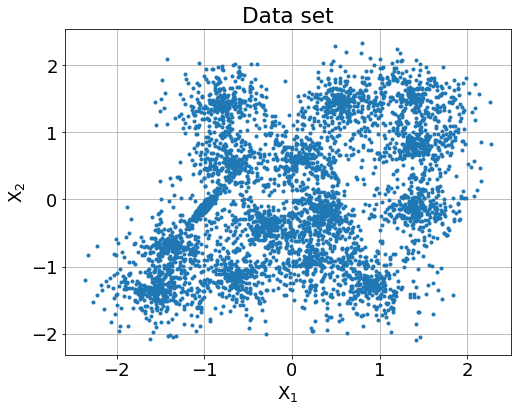

In [40]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8,6))
plt.plot(data[:,0],data[:,1],'.')
plt.xlabel("X$_1$")
plt.ylabel("X$_2$")
plt.title("Data set")
plt.grid("on")
plt.show()

## 1.c) Repeat 100 times k-means with $k = 15$ 

In [45]:
start_time = time.time()

k = 15
ntrials = 100
clusters_trials = {}
centroids_trials = {}
objective_func_trials = []
niterations_trials = []
for i in range(ntrials):
    clusters, centroids, objective_func, niterations = k_means(data, k=k)
    clusters_trials[i] = clusters
    centroids_trials[i] = centroids
    objective_func_trials.append(objective_func)
    niterations_trials.append(niterations)
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 0.1 minutes


Best and average value of the (minimized) objective function:

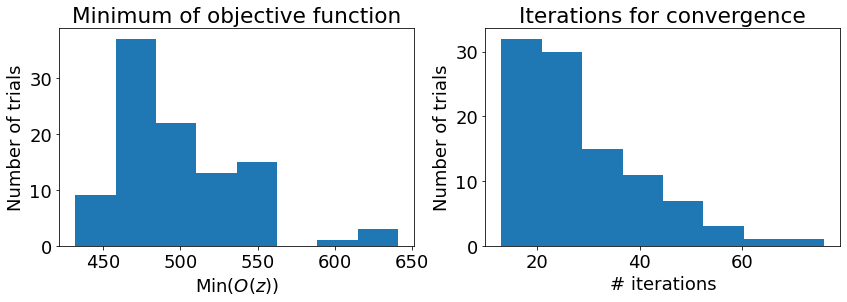

Best convergence achieved in 28 steps to min(O(z)) = 431.99
Average min(O(z)) reached: < min(O(z)) > = 500.30
Average number of iterations: 28


In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.hist(objective_func_trials,bins=8)
ax1.set(title="Minimum of objective function",xlabel="Min($O(z)$)",ylabel="Number of trials")
ax2.hist(niterations_trials,bins=8)
ax2.set(title="Iterations for convergence",xlabel="# iterations",ylabel="Number of trials")
plt.show()

best_trial_index = np.argmin(objective_func_trials)
print("Best convergence achieved in " + str(niterations_trials[best_trial_index]) + 
      " steps to min(O(z)) = {:.2f}".format(objective_func_trials[best_trial_index]))

comparison_objective_func = {}
average_objective_func = np.mean(objective_func_trials)
comparison_objective_func['k-means'] = average_objective_func
print("Average min(O(z)) reached: < min(O(z)) > = {:.2f}".format(average_objective_func)) 

comparison_niterations = {}
average_niterations = int(np.mean(niterations_trials))
comparison_niterations['k-means'] = average_niterations
print("Average number of iterations: " + str(average_niterations)) 

Plot of the assigned clusters (visualized by color) for the best case:

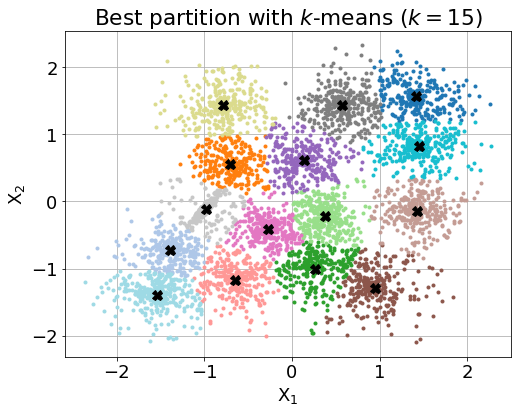

In [47]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8,6))
colors = plt.cm.tab20(np.linspace(0.,1,k))
for cluster_index in range(k):
    elements = clusters_trials[best_trial_index][cluster_index]
    plt.plot(data[elements,0],data[elements,1],'.',color=colors[cluster_index])
plt.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
plt.xlabel("X$_1$")
plt.ylabel("X$_2$")
plt.title("Best partition with $k$-means ($k = {:d}$)".format(k))
plt.grid("on")
plt.show()

## 1.d) k-means++
The algorithm works as standard k-means, but with a different initialization routine for the centroids:
- Pick randomly only the first centroid $c_0$
- Iterate the following steps to choose the remaining centroids $c_l$:
    - For each point $X_i$, compute the mininum distance $D_{X_i} $  from the centroids already assigned: 
    \begin{equation}
        D_{X_i} = \underset{l}{\text{min}}\| X_i - c_l \| 
    \end{equation}
    - Extract the new centroid sampling from the dataset $\{X_i\}$ with probabilities $p_i\propto D_{X_i}^2$

In [48]:
start_time = time.time()

k = 15
ntrials = 100
clusters_trials = {}
centroids_trials = {}
objective_func_trials = []
niterations_trials = []
for i in range(ntrials):
    clusters, centroids, objective_func, niterations = k_means(data, k=k, case='++')
    clusters_trials[i] = clusters
    centroids_trials[i] = centroids
    objective_func_trials.append(objective_func)
    niterations_trials.append(niterations)
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 0.1 minutes


Best and average value of the (minimized) objective function:

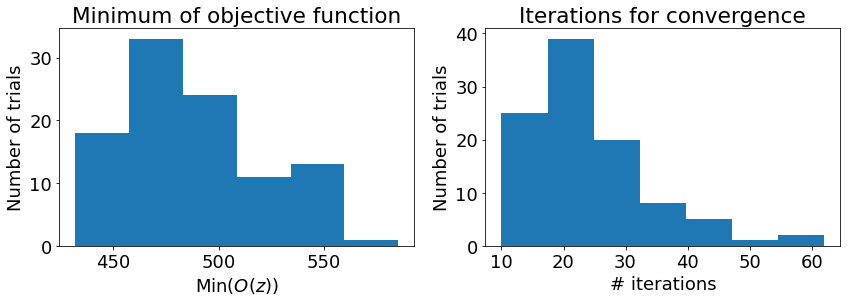

Best convergence achieved in 12 steps to min(O(z)) = 431.99
Average min(O(z)) reached: < min(O(z)) > = 487.12
Average number of iterations: 24


In [52]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.hist(objective_func_trials,bins=6)
ax1.set(title="Minimum of objective function",xlabel="Min($O(z)$)",ylabel="Number of trials")
ax2.hist(niterations_trials,bins=7)
ax2.set(title="Iterations for convergence",xlabel="# iterations",ylabel="Number of trials")
plt.show()

best_trial_index = np.argmin(objective_func_trials)
print("Best convergence achieved in " + str(niterations_trials[best_trial_index]) + 
      " steps to min(O(z)) = {:.2f}".format(objective_func_trials[best_trial_index]))

average_objective_func = np.mean(objective_func_trials)
comparison_objective_func['k-means++'] = average_objective_func
print("Average min(O(z)) reached: < min(O(z)) > = {:.2f}".format(average_objective_func)) 

average_niterations = int(np.mean(niterations_trials))
comparison_niterations['k-means++'] = average_niterations
print("Average number of iterations: " + str(average_niterations)) 

Plot of the assigned clusters (visualized by color) for the best case:

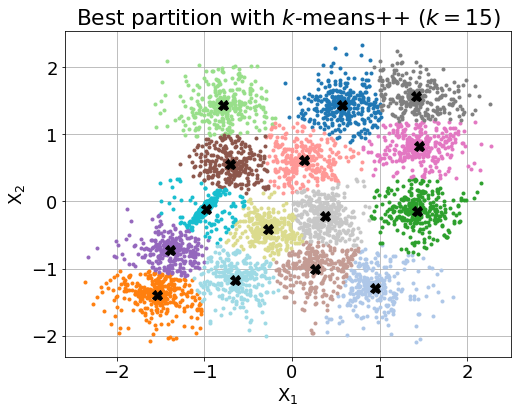

In [53]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8,6))
colors = plt.cm.tab20(np.linspace(0.,1,k))
for cluster_index in range(k):
    elements = clusters_trials[best_trial_index][cluster_index]
    plt.plot(data[elements,0],data[elements,1],'.',color=colors[cluster_index])
plt.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
plt.xlabel("X$_1$")
plt.ylabel("X$_2$")
plt.title("Best partition with $k$-means++ ($k = {:d}$)".format(k))
plt.grid("on")
plt.show()

## 1.e) scree plot for $k\in[2,20]$ using k-means++

In [54]:
start_time = time.time()

objective_func_scree = []
for k in range(2,20+1):
    ntrials = 100
    objective_func_trials = []
    for i in range(ntrials):
        clusters, centroids, objective_func, niterations = k_means(data, k=k, case='++')
        objective_func_trials.append(objective_func)
    objective_func_scree.append(min(objective_func_trials))
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 1.1 minutes


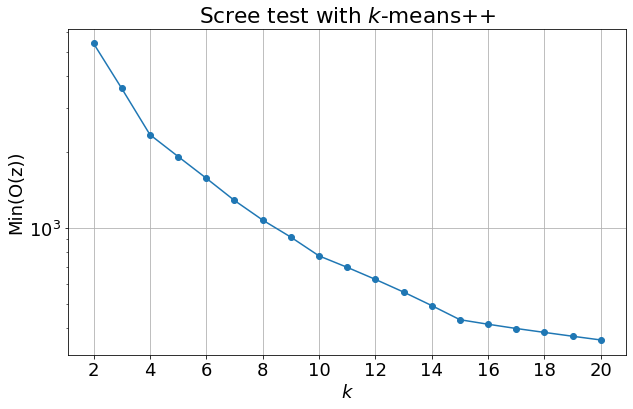

In [55]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(2,20+1),objective_func_scree,'o-')
plt.ylabel("Min(O(z))")
plt.yscale("log")
plt.xlabel("$k$")
plt.title("Scree test with $k$-means++")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.grid("on")
plt.show()

## 1.f) k-medoids

The algorithm works as k-means, but replacing for each cluster $l$ the centroid $c_l$ with the medoid $m_l$, defined as the point of the cluster with the minimum sum of distances from the other points of the cluster:
\begin{equation}
    m_l = \underset{X_i | z_i = l}{\text{argmin}} \sum_{j}\delta_{lz_j} \|X_i - X_j \|
\end{equation}

In [56]:
def k_medoids(data, k=15, case='standard'):
    N = data.shape[0]
    D = data.shape[1]
    
    # initialize medoids
    if case == 'standard':
        medoids = data[np.random.choice(N ,size=k, replace=False),:]
    elif case == '++':
        medoids = np.zeros((k,D))
        medoids[0,:] = data[np.random.choice(N),:] # pick randomly only first medoid
        k_chosen = 1
        while(k_chosen < k):
            d_x = np.min(euclidean_distances(data,medoids),axis=1)
            probabilities = d_x**2 / np.sum(d_x**2)
            medoids[k_chosen,:] = data[np.random.choice(N,p=probabilities)]
            k_chosen += 1
    
    # iterative redefinition of medoids
    convergence = np.zeros(k,dtype=bool)
    niterations = 0
    while not np.all(convergence):
        cluster_indices = np.argmin(euclidean_distances(data,medoids),axis=1)
        # update medoids
        for cluster_index in range(k):
            cluster_elements = np.where(cluster_indices==cluster_index)[0] 
            if cluster_elements.size != 0:
                distance_matrix_cluster = euclidean_distances(data[cluster_elements,:],data[cluster_elements,:])
                new_medoid = compute_medoid(data[cluster_elements,:],distance_matrix_cluster)
            else: new_medoid = medoids[cluster_index]
            convergence[cluster_index] = np.array_equal(medoids[cluster_index,:],new_medoid)
            medoids[cluster_index] = new_medoid
        niterations += 1
    
    # compute local minimum of objective function
    objective_func = 0
    clusters = {}  
    distances2_data_medoids = euclidean_distances(data,medoids,squared=True)
    for cluster_index in range(k):
        cluster_elements = np.where(cluster_indices==cluster_index)[0]
        objective_func += sum(distances2_data_medoids[cluster_elements,cluster_index])
        clusters[cluster_index] = cluster_elements
    
    return clusters, medoids, objective_func, niterations

@numba.njit(fastmath=True)
def compute_medoid(data_cluster,distance_matrix_cluster): 
    N_cluster = distance_matrix_cluster.shape[0]
    
    sum_of_distances = np.sum(distance_matrix_cluster,axis=1)
    
    medoid_index = np.argmin(sum_of_distances)
    medoid = data_cluster[medoid_index,:]
    return medoid

In [57]:
start_time = time.time()

k = 15
ntrials = 100
clusters_trials = {}
centroids_trials = {}
objective_func_trials = []
niterations_trials = []
for i in range(ntrials):
    clusters, centroids, objective_func, niterations = k_medoids(data, k=k, case='++')
    clusters_trials[i] = clusters
    centroids_trials[i] = centroids
    objective_func_trials.append(objective_func)
    niterations_trials.append(niterations)
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 0.2 minutes


Best and average value of the (minimized) objective function:

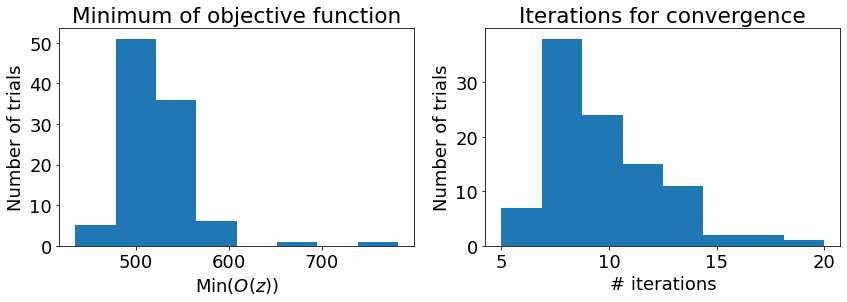

Best convergence achieved in 9 steps to min(O(z)) = 434.43
Average min(O(z)) reached: < min(O(z)) > = 521.14
Average number of iterations: 9


In [64]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.hist(objective_func_trials,bins=8)
ax1.set(title="Minimum of objective function",xlabel="Min($O(z)$)",ylabel="Number of trials")
ax2.hist(niterations_trials,bins=8)
ax2.set(title="Iterations for convergence",xlabel="# iterations",ylabel="Number of trials")
plt.show()

best_trial_index = np.argmin(objective_func_trials)
print("Best convergence achieved in " + str(niterations_trials[best_trial_index]) + 
      " steps to min(O(z)) = {:.2f}".format(objective_func_trials[best_trial_index]))

average_objective_func = np.mean(objective_func_trials)
comparison_objective_func['k-medoids++'] = average_objective_func
print("Average min(O(z)) reached: < min(O(z)) > = {:.2f}".format(average_objective_func)) 

average_niterations = int(np.mean(niterations_trials))
comparison_niterations['k-medoids++'] = average_niterations
print("Average number of iterations: " + str(average_niterations)) 

Plot of the assigned clusters (visualized by color) for the best case:

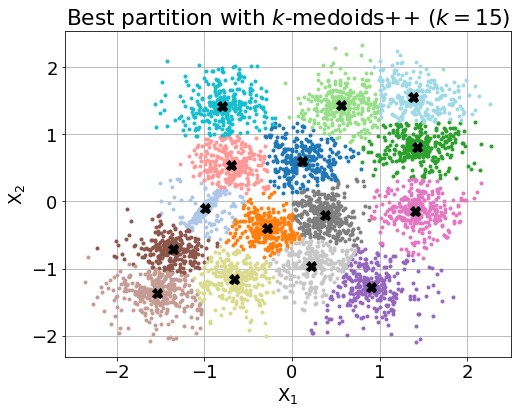

In [59]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8,6))
colors = plt.cm.tab20(np.linspace(0.,1,k))
for cluster_index in range(k):
    elements = clusters_trials[best_trial_index][cluster_index]
    plt.plot(data[elements,0],data[elements,1],'.',color=colors[cluster_index])
plt.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
plt.xlabel("X$_1$")
plt.ylabel("X$_2$")
plt.title("Best partition with $k$-medoids++ ($k = {:d}$)".format(k))
plt.grid("on")

## 1.e) scree plot for $k\in[2,20]$ using k-medoids++

In [65]:
start_time = time.time()

objective_func_scree = []
for k in range(2,20+1):
    ntrials = 100
    objective_func_trials = []
    for i in range(ntrials):
        clusters, centroids, objective_func, niterations = k_medoids(data, k=k, case='++')
        objective_func_trials.append(objective_func)
    objective_func_scree.append(min(objective_func_trials))
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 6.4 minutes


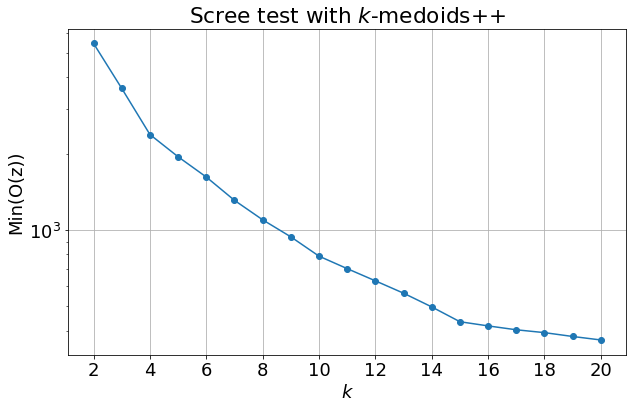

In [66]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(2,20+1),objective_func_scree,'o-')
plt.ylabel("Min(O(z))")
plt.yscale("log")
plt.xlabel("$k$")
plt.title("Scree test with $k$-medoids++")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.grid("on")

## Flat clustering comparison: k-means, k-means++, k-medoids++

In [67]:
from tabulate import tabulate
table = [['Algorithm', '< min(O(z)) >', '< # iterations >'], 
         ['k-means',comparison_objective_func['k-means'], comparison_niterations['k-means']],
         ['k-means++',comparison_objective_func['k-means++'], comparison_niterations['k-means++']],
         ['k-medoids++',comparison_objective_func['k-medoids++'], comparison_niterations['k-medoids++']]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═════════════════╤════════════════════╕
│ Algorithm   │   < min(O(z)) > │   < # iterations > │
╞═════════════╪═════════════════╪════════════════════╡
│ k-means     │         500.3   │                 28 │
├─────────────┼─────────────────┼────────────────────┤
│ k-means++   │         487.124 │                 24 │
├─────────────┼─────────────────┼────────────────────┤
│ k-medoids++ │         521.141 │                  9 │
╘═════════════╧═════════════════╧════════════════════╛


# 2) fuzzy c-means
The algorithm generalizes k-means to a soft-partition fashion where each data point $X-i$ is assigned to each cluster $l$ with a degree of membership $U_{il}$, defining a $N\times k$ matrix which is normalized along each raw:
\begin{equation}
    \sum_{l=1}^k U_{il} = 1 \hspace{0.3cm} \forall i = 1,...,N\,.
\end{equation}
The scheme of the algorithm is the following:
- Initialize randomly the matrix $U$;
- Iterate until the variation of U is small enough (exit condition: $|U'_{il} - U_{il}| < \varepsilon\,\, \forall i,l$):
    - Compute the centroids $c_l$:
    \begin{equation}
        c_l = \frac{\sum_i U_{il}^m\,X_i}{\sum_i U_{il}^m}\,;
    \end{equation}
    - Update the matrix $U$:
    \begin{equation}
        U_{ij} = \frac{1}{\sum_{l=1}^k \left(\frac{\|X_i - c_j \|}{\|X_i - c_l\|}\right)^{2/(m-1)}}\,;
    \end{equation}

In [20]:
def fuzzy_c_means(data, k=15, m=2, epsilon=1e-3):
    N = data.shape[0]
    D = data.shape[1]

    # initialize membership matrix U
    U = np.random.random((N,k))
    for i in range(N):
        U[i,:] /= np.sum(U[i,:])

    # iterative redefinition of centroids
    convergence = np.array([[False for i in range(N)] for j in range(k)]) #np.zeros((N,k),dtype=bool)
    niterations = 0
    while not convergence.all(): 
        # update centroids
        centroids = compute_centroids(data,U,m=m)
        # update membership matrix U
        distances_data_centroids = euclidean_distances(data,centroids)
        new_U = compute_membership(distances_data_centroids,centroids,m=m)   
        #convergence = np.abs((new_U-U)/U) < epsilon*np.abs(U)
        convergence = np.abs(new_U-U) < epsilon*np.ones((N,k))
        U = new_U
        niterations += 1
        
    # compute local minimum of objective function
    obj_func = compute_obj_func_fuzzycmeans(data,U,centroids,m=m)
    
    return U, centroids, obj_func, niterations

@numba.njit(fastmath=True)
def compute_centroids(data,U,m=2):
    N = data.shape[0]
    D = data.shape[1]
    k = U.shape[1]
    centroids = np.zeros((k,D))
    for cluster_index in range(k):
        denominator = np.sum(U[:,cluster_index]**m)
        for dim in range(D):
            centroids[cluster_index,dim] = np.dot(U[:,cluster_index]**m,np.ascontiguousarray(data[:,dim]))
        centroids[cluster_index,:] /= denominator
    return centroids

@numba.njit(fastmath=True)
def compute_membership(distances_data_centroids,centroids,m=2):
    N = distances_data_centroids.shape[0]
    k = centroids.shape[0]
    U = np.zeros((N,k))
    exponent = 2/(m-1)
    for i in range(N):
        for j in range(k):
            denominator = 0.0
            factor_ij = distances_data_centroids[i,j]**exponent
            for l in range(k):
                denominator += (1 / distances_data_centroids[i,l])**exponent
            U[i,j] = 1.0 / (factor_ij*denominator) 
    return U

@numba.njit(fastmath=True)
def compute_obj_func_fuzzycmeans(data,U,centroids,m=2):
    N = data.shape[0]
    obj_func = 0
    for cluster_index in range(k):
        for i in range(N):
            obj_func += U[i,cluster_index]**m * np.linalg.norm(data[i,:]-centroids[cluster_index,:])**2
    return obj_func

In [21]:
start_time = time.time()

k = 15
epsilon=1e-3
ntrials = 100
U_trials = {}
centroids_trials = {}
objective_func_trials = []
niterations_trials = []
for i in range(ntrials):
    U, centroids, objective_func, niterations = fuzzy_c_means(data, k=k, epsilon=epsilon)
    U_trials[i] = U
    centroids_trials[i] = centroids
    objective_func_trials.append(objective_func)
    niterations_trials.append(niterations)
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 2.9 minutes


Best, worst and average value of the (minimized) objective function:

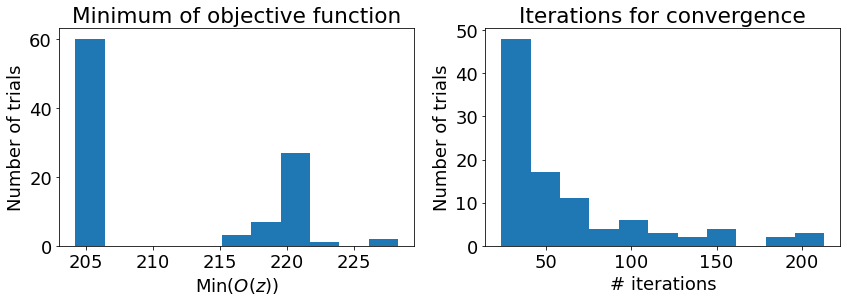

Best convergence achieved in 32 steps to min(O(z)) = 204.24
Average min(O(z)) reached: < min(O(z)) > = 210.62


In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.hist(objective_func_trials,bins=11)
ax1.set(title="Minimum of objective function",xlabel="Min($O(z)$)",ylabel="Number of trials")
ax2.hist(niterations_trials,bins=11)
ax2.set(title="Iterations for convergence",xlabel="# iterations",ylabel="Number of trials")
plt.show()

best_trial_index = np.argmin(objective_func_trials)
print("Best convergence achieved in " + str(niterations_trials[best_trial_index]) + 
      " steps to min(O(z)) = {:.2f}".format(objective_func_trials[best_trial_index]))

average_objective_func = np.mean(objective_func_trials)
print("Average min(O(z)) reached: < min(O(z)) > = {:.2f}".format(average_objective_func)) 

Plot of the assigned clusters (visualized by color) for the best case:

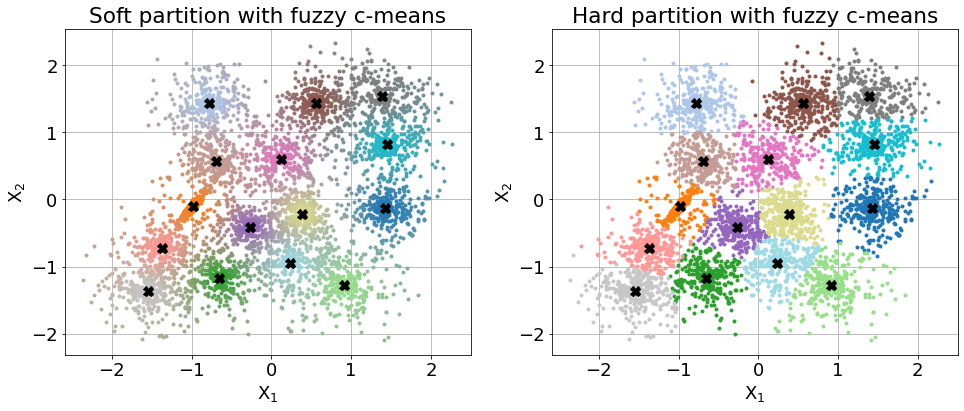

In [35]:
plt.rcParams['font.size'] = 18
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
colors = plt.cm.tab20(np.linspace(0.,1,k))
N = data.shape[0]

for i in range(N):
    color_i = np.zeros(3)
    for j in range(k):
        color_i += colors[j,:3]*U_trials[best_trial_index][i,j]
    color_i=np.append(color_i,1.).tolist()
    ax1.plot(data[i,0],data[i,1],'.',color=color_i)
ax1.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
ax1.set_xlabel("X$_1$")
ax1.set_ylabel("X$_2$")
ax1.set_title("Soft partition with fuzzy c-means")
ax1.grid("on")

clusters_hard_partition = {}
hard_assignments = np.argmax(U_trials[best_trial_index],axis=1)
for cluster_index in range(k):
    cluster_indices = np.where(hard_assignments==cluster_index)[0]
    ax2.plot(data[cluster_indices,0],data[cluster_indices,1],'.',color=colors[cluster_index])
ax2.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
ax2.set_xlabel("X$_1$")
ax2.set_ylabel("X$_2$")
ax2.set_title("Hard partition with fuzzy c-means")
ax2.grid("on")
plt.show()

## 1.e) scree plot for $k\in[2,20]$ using fuzzy c-means

In [8]:
start_time = time.time()

epsilon = 1e-3
objective_func_scree = []
for k in range(2,20+1):
    print("Running case k = " + str(k) + "...")
    ntrials = 100
    objective_func_trials = []
    for i in range(ntrials):
        U, centroids, objective_func, niterations = fuzzy_c_means(data, k=k, epsilon=epsilon)
        objective_func_trials.append(objective_func)
    objective_func_scree.append(min(objective_func_trials))
    
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Running case k = 2...
Running case k = 3...
Running case k = 4...
Running case k = 5...
Running case k = 6...
Running case k = 7...
Running case k = 8...
Running case k = 9...
Running case k = 10...
Running case k = 11...
Running case k = 12...
Running case k = 13...
Running case k = 14...
Running case k = 15...
Running case k = 16...
Running case k = 17...
Running case k = 18...
Running case k = 19...
Running case k = 20...
Execution time: 85.2 minutes


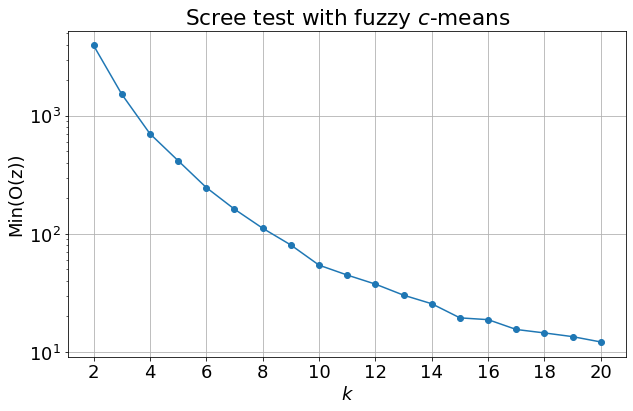

In [17]:
plt.figure(figsize=(10,6))
ax = plt.plot(np.arange(2,20+1),objective_func_scree,'o-')
plt.ylabel("Min(O(z))")
plt.yscale("log")
plt.xlabel("$k$")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
plt.title("Scree test with fuzzy $c$-means")
plt.grid("on")